In [1]:
from neurotron import Attribute, Matrix, Cluster,Token
from neurotron import Ansi, Cell, Record, isa
import neurotron.math as nm


In [2]:
#===========================================================================
# helper: check cell's movie with given pattern
#===========================================================================

def check(cells,pattern):
    """
    check(): check recorder pattern of a network of cells against a given
             pattern and raise exception if check fails.
    >>> par,token = toy('sarah')
    >>> cells = Cells(3,par,[3,10])
    >>> y = cells.iteration([0,0,0]+token['Sarah'])
    >>> check(cells,'|U,U,QB,QBY,DY,D--|---D,XD,X,X,X|---D,D---|')
    """
    p = cells.record.pattern()
    if p != pattern:
        print('expected: ',pattern)
        print('got:      ',p)
        raise Exception('pattern check failed')



In [3]:
class Synapse(Exception):
    """
    class Synapse: exception to raise if there are no more free synapses
    """
    pass

class Cells(Cluster):
    def __init__(self,shape,token=None):
        nm.seed(1)
        cells = super().__init__(*shape,verbose=1)
        self.token = token
        m,n,d,s = shape
        f = [0,0,0] if token is None else token['.']
        self.y = nm.row(nm.zeros(1,m*n),f)
        self.record = Record(self)

    def process(self,word):
        m,n,d,s = self.shape
        self.y = nm.row(nm.zeros(1,m*n),token[word])
        self.y = self.step(self.y,word)

    def predictive(self,list):
        for k in list:
            cells.X[k] = 1;
            cells._predict.I[k] = Matrix([[.1,-.1,.1,-.1,.1],[0,0,0,0,0]])

    def __str__(self):
        self.record.clear();  
        self.record(self)
        return self.record.pattern()

    def __repr__(self):
        return self.__str__()

    def connect(self,idx,kdx):
        """
        >>> cells = Cells()
        >>> cells.connect([0,14,16,12,12],[2])
        """
        assert isa(idx,list)
        assert isa(kdx,list)
        m,n,d,s = self.shape
        if len(idx) > s: 
            raise Exception('more than %g indices provided (arg2)'%s)
        predict = self._predict

        for k in kdx:
            done = False
            for ii in range(d):
                if nm.all(predict.P[k][ii,:]==0):
                    for jj in range(s):
                        predict.K[k][ii,jj] = 0
                    for jj in range(len(idx)):
                        predict.K[k][ii,jj] = idx[jj]
                        predict.P[k][ii,jj] = 0.5
                    done = True
                    break
            if not done:
                print('K[%g]' % k, predict.K[k])
                raise Synapse('no free synapses to connect: [%g]'%k)
                

In [4]:
#=========================================================================
# setup network
#=========================================================================

token = Token({'Mary': [1,0,0,0,0,0,0,1,1],
               'John': [0,1,0,0,0,0,0,1,1],
               'Lisa': [1,0,0,0,0,0,1,1,0],
               'likes':[0,0,1,0,0,0,0,1,1],
               'to':   [0,0,0,1,0,0,0,1,1],
               'sing': [0,0,0,0,1,0,0,1,1],
               'dance':[0,0,0,0,0,1,0,1,1],
               'hike': [0,0,0,0,1,0,1,1,0],
               '.':    [0,0,0,0,0,0,1,1,1],
               })
    
def setup(token):
    shape = (2,9,4,3);  
    cells = Cells(shape,token)
    cells._predict.clear()

    try:
        cells.connect([0,14,16],[4,14,16])  # Mary(0,14,16) -> likes(4,14,16)
        cells.connect([4,14,16],[6,14,16])  # likes(4,14,16) -> to(6,14,16)
        cells.connect([6,14,16],[8,14,16])  # to(6,14,16) -> sing(8,14,16)
        cells.connect([8,14,16],[12,14,16]) # sing(8,14,16) -> .(12,14,16)

        cells.connect([2,14,16],[5,14,16])  # John(2,14,16) -> likes(5,14,16)  
        cells.connect([5,14,16],[7])        # likes(5,14,16) -> to(7,14,16)
        cells.connect([7,14,16],[10])       # to(7,14,16) -> dance(10,14,16)
        cells.connect([10,14,16],[12])      # dance(10,14,16) -> .(12,14,16)
    except Synapse as s:
        print(Ansi.R,'*** warning:',str(s),Ansi.N)
        
    return cells

cells = setup(token)
print(cells.shape)


K[14] [0 14 16; 4 14 16; 6 14 16; 8 14 16]
 *** warning: no free synapses to connect: [14] 
(2, 9, 4, 3)


mind I[4].0: [0.1 0.1 0.1]
mind I[14].0: [0.1 0.1 0.1]
mind I[16].0: [0.1 0.1 0.1]


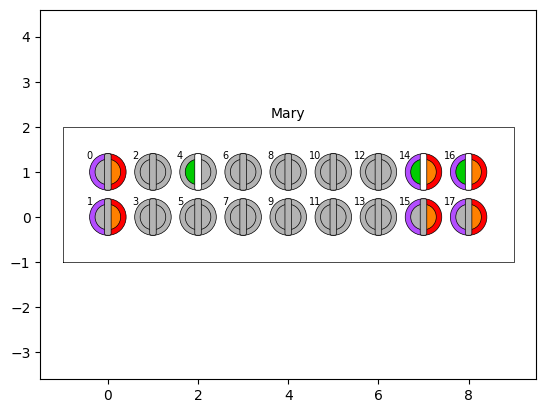

In [5]:
cells.process('Mary')
#check(cells,'|UQBY|UQBY|-|-|XS|-|-|-|-|-|-|-|-|-|UQBY|UQBY|UQBY|UQBY|')

learn P[4].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[14].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[16].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[6].0: [0.1 0.1 0.1]
mind I[14].1: [0.1 0.1 0.1]
mind I[16].1: [0.1 0.1 0.1]


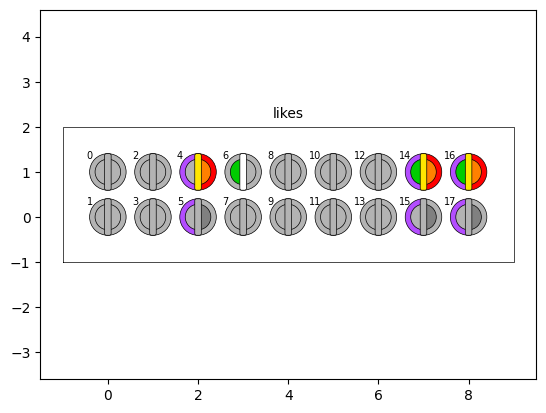

In [6]:
cells.process('likes')

learn P[6].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[14].1: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[16].1: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[8].0: [0.1 0.1 0.1]
mind I[14].2: [0.1 0.1 0.1]
mind I[16].2: [0.1 0.1 0.1]


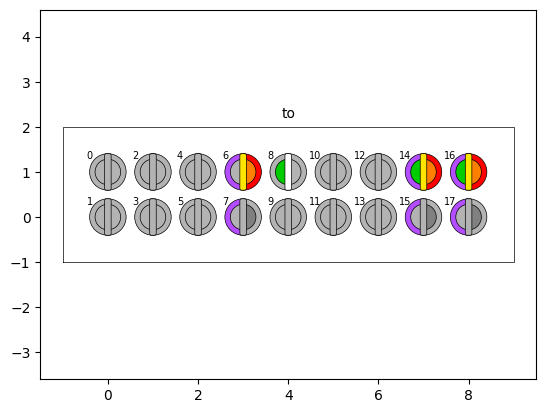

In [7]:
cells.process('to')

learn P[8].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[14].2: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[16].2: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[12].0: [0.1 0.1 0.1]
mind I[14].3: [0.1 0.1 0.1]
mind I[16].3: [0.1 0.1 0.1]


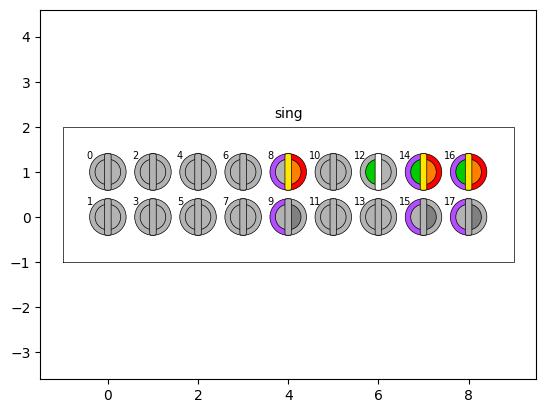

In [8]:
cells.process('sing')

learn P[12].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[14].3: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[16].3: [0.6 0.6 0.6] by [0.1 0.1 0.1]


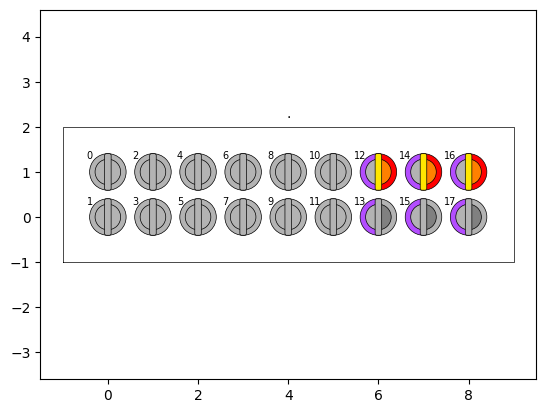

In [9]:
cells.process('.')

mind I[5].0: [0.1 0.1 0.1]


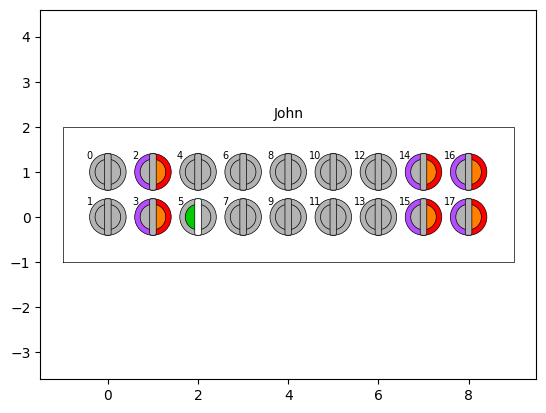

In [10]:
cells.process('John')

learn P[5].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]


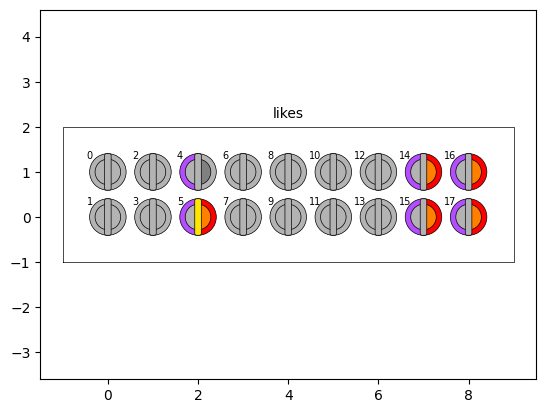

In [11]:
cells.process('likes')

mind I[8].0: [0.1 0.1 0.1]
mind I[14].2: [0.1 0.1 0.1]
mind I[16].2: [0.1 0.1 0.1]


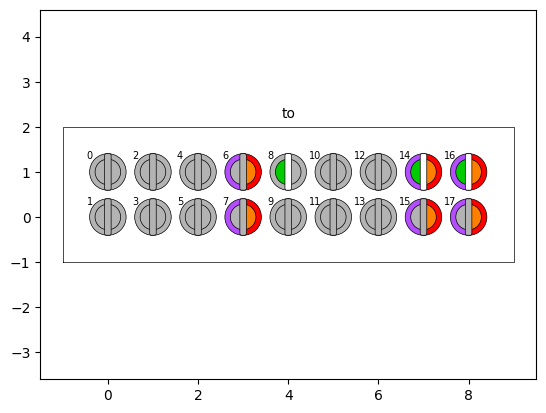

In [12]:
cells.process('to')

learn P[14].2: [0.7 0.7 0.7] by [0.1 0.1 0.1]
learn P[16].2: [0.7 0.7 0.7] by [0.1 0.1 0.1]


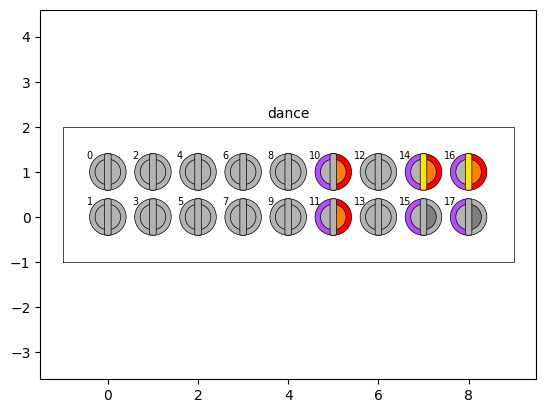

In [13]:
cells.process('dance')

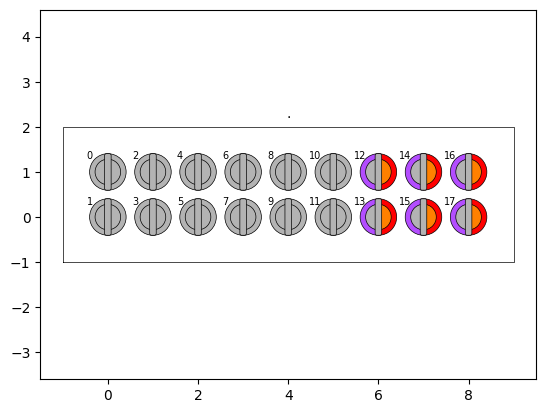

In [14]:
cells.process('.')

In [15]:
cells.shape

(2, 9, 4, 3)